<a href="https://colab.research.google.com/github/Jeff-004/Projects/blob/main/Time_Series_Forecasting_of_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/Datasets/NFLX.csv", index_col='Date')
df.index = pd.to_datetime(df.index)

# Resample to weekly frequency and compute log returns
df_week = df.resample('W').mean()
df_week = df_week[['Close']]
df_week['weekly_ret'] = np.log(df_week['Close']).diff()
df_week = df_week[df_week['weekly_ret'].notnull()]

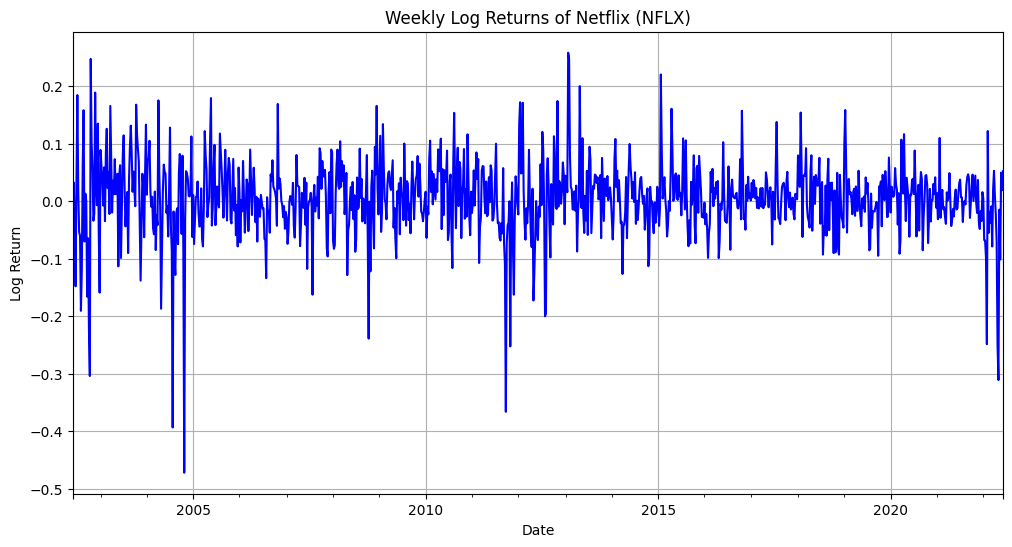

In [18]:
df_week['weekly_ret'].plot(kind='line', figsize=(12, 6), color='blue')
plt.title("Weekly Log Returns of Netflix (NFLX)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

In [19]:
udiff = df_week[['weekly_ret']]  # Keep as DataFrame for compatibility

rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

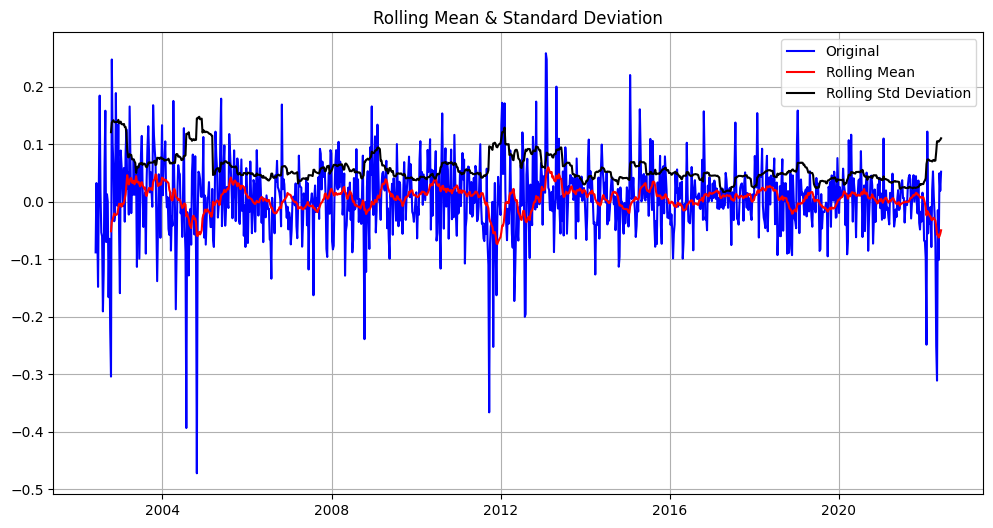

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(udiff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [21]:
# Dickey-Fuller test
dftest = adfuller(udiff['weekly_ret'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

Test Statistic                -1.675527e+01
p-value                        1.323754e-29
#Lags Used                     2.000000e+00
Number of Observations Used    1.042000e+03
Critical Value (1%)           -3.436641e+00
Critical Value (5%)           -2.864318e+00
Critical Value (10%)          -2.568249e+00
dtype: float64


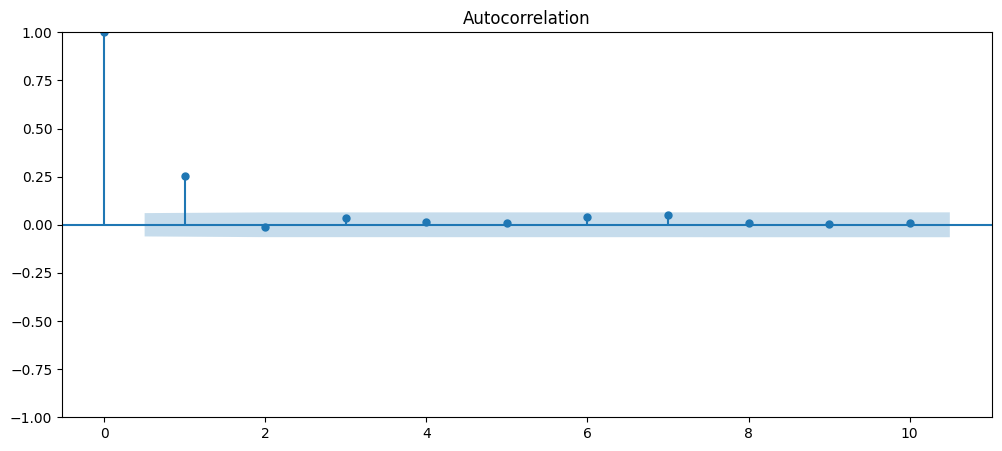

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff['weekly_ret'], lags=10, ax=ax)
plt.show()

In [23]:
import itertools

# Candidate ranges for p, d, q
p = range(0, 4)
d = range(0, 2)  # allow differencing
q = range(0, 4)

best_aic = np.inf
best_order = None
best_model = None

for order in itertools.product(p, d, q):
    try:
        model = ARIMA(udiff['weekly_ret'], order=order)
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception as e:
        continue

if best_order:
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
else:
    print("No valid ARIMA model found.")

Best ARIMA order: (0, 0, 1) with AIC: -2797.025806159985


In [24]:
import warnings
warnings.filterwarnings("ignore")

# Fit ARIMA directly to the pandas Series to preserve the index
arima_model = ARIMA(udiff['weekly_ret'], order=(0,0,1))
arima_fit = arima_model.fit()
print("ARIMA(0,0,1) Model Results")
print("-" * 30)
print("AIC:", round(arima_fit.aic, 3))
print("BIC:", round(arima_fit.bic, 3))
print("Log Likelihood:", round(arima_fit.llf, 3))

ARIMA(0,0,1) Model Results
------------------------------
AIC: -2797.026
BIC: -2782.17
Log Likelihood: 1401.513


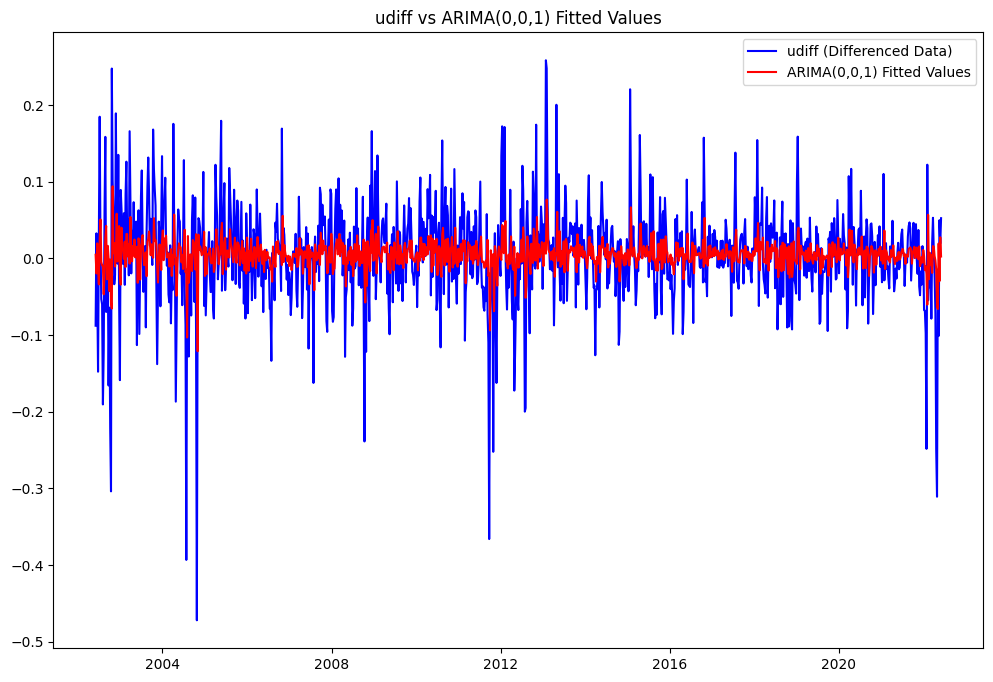

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'], color='blue', label='udiff (Differenced Data)')
plt.plot(arima_fit.fittedvalues, color='red', label='ARIMA(0,0,1) Fitted Values')
plt.legend()
plt.title('udiff vs ARIMA(0,0,1) Fitted Values')
plt.show()

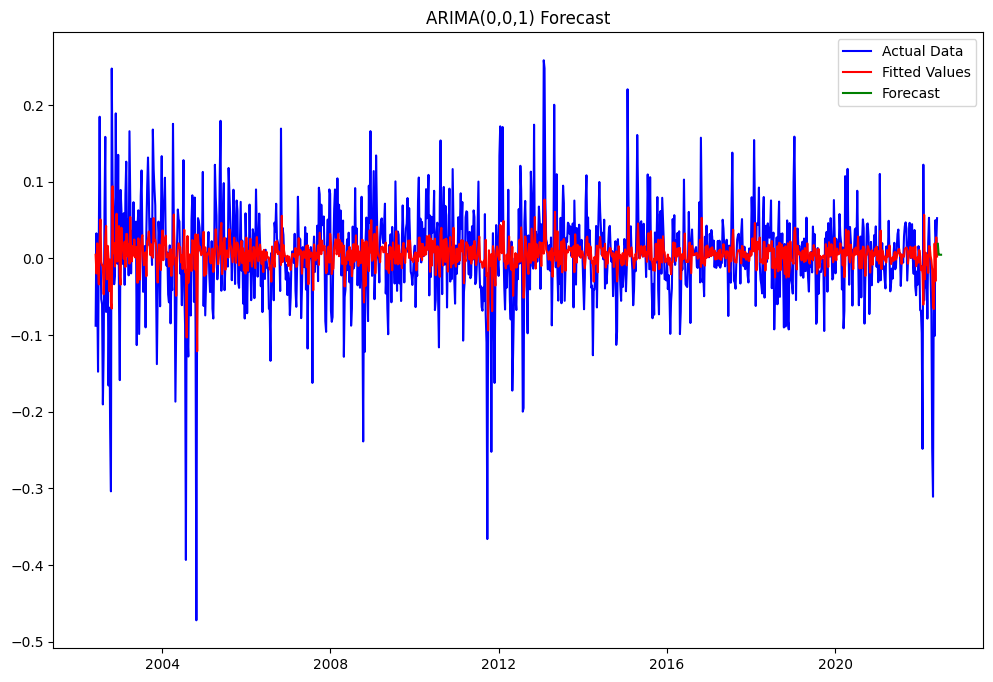

In [26]:
# Fit the ARIMA model
ar1 = ARIMA(udiff['weekly_ret'], order=(0,0,1))  # Use the Series, not .values
ar1_fit = ar1.fit()

# Forecast future values
steps = 5
forecast = ar1_fit.get_forecast(steps=steps)

# Generate future dates aligned with the original index
last_date = udiff.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=steps, freq='W')

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(udiff.index, udiff['weekly_ret'], color='blue', label='Actual Data')
plt.plot(ar1_fit.fittedvalues.index, ar1_fit.fittedvalues, color='red', label='Fitted Values')
plt.plot(future_dates, forecast.predicted_mean, color='green', label='Forecast')

plt.title('ARIMA(0,0,1) Forecast')
plt.legend()
plt.show()

In [27]:
#For predicted means
predicted_means = forecast.predicted_mean
print("Predicted Means:\n",predicted_means)

Predicted Means:
 2022-06-12    0.019131
2022-06-19    0.004868
2022-06-26    0.004868
2022-07-03    0.004868
2022-07-10    0.004868
Freq: W-SUN, Name: predicted_mean, dtype: float64


In [29]:
import math
# Accuracy metrics
actual = udiff['weekly_ret']            # actual data
fitted = ar1_fit.fittedvalues           # in-sample model predictions

rmse = math.sqrt(mean_squared_error(actual, fitted))
mae = mean_absolute_error(actual, fitted)
mape = np.mean(np.abs((actual - fitted) / np.where(actual == 0, 1e-10, actual))) * 100

print("Accuracy Metrics:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

Accuracy Metrics:
RMSE: 0.063
MAE: 0.044
